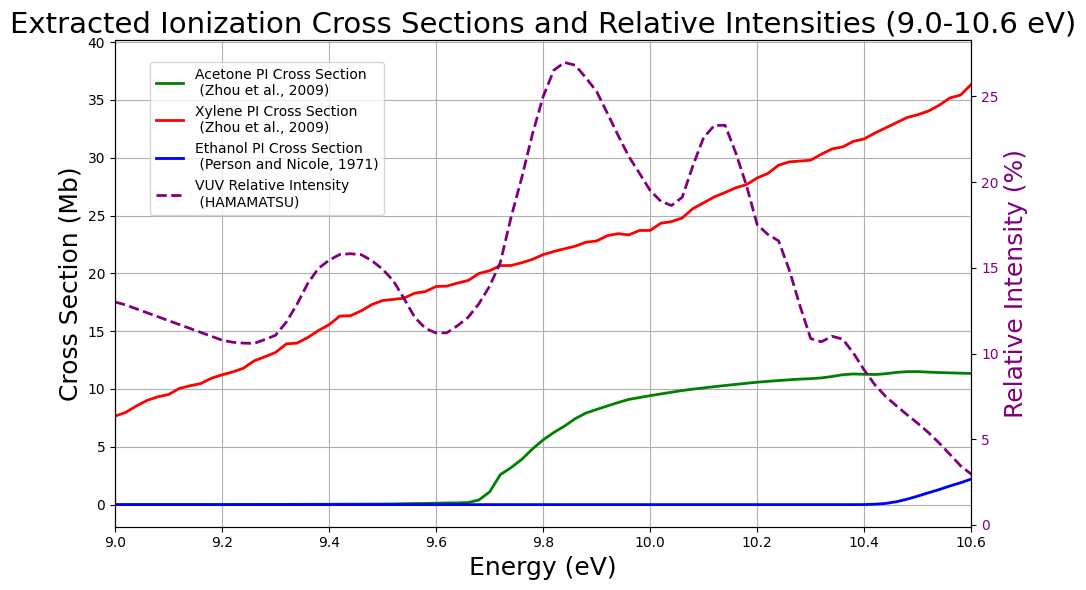

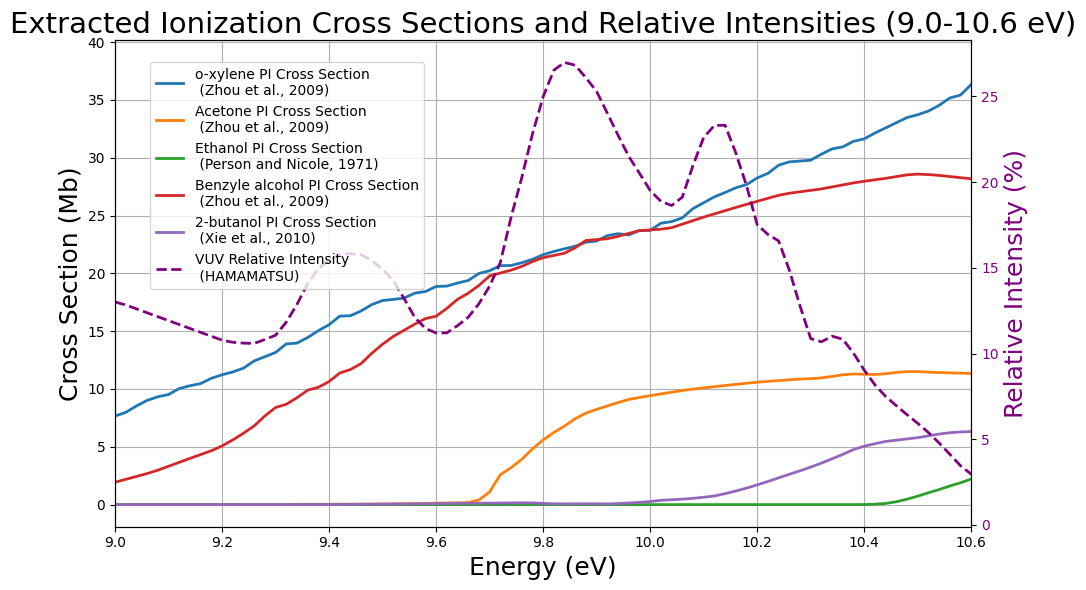

In [355]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# ファイルパスを指定
files = [
    '0-xylene_PI_CS.csv',
    'acetone_PI_CS.csv',
    'ethanol_PI_CS.csv',
    'benzyle_PI_CS.csv',
    'isobutanol_PI_CS.csv',
    'VUV.csv',
    'VUV_direction_distribution.csv'
]
names = [
    'o-xylene',
    'Acetone',
    'Ethanol',
    'Benzyle alcohol',
    '2-butanol',
]
refs = [
    'Zhou et al., 2009',
    'Zhou et al., 2009',
    'Person and Nicole, 1971',
    'Zhou et al., 2009',
    'Xie et al., 2010',    
]

# エネルギー範囲を設定（9.0 eV から、0.2 eV刻み）
energy_range = np.arange(9.0, 10.7, 0.02)

# 各CSVファイルを読み込み、エネルギー(eV)と光イオン化断面積(Mb)の配列に格納
def load_data(file_path):
    data = pd.read_csv(file_path, header=None)
    return data[0].values, data[1].values  # 1列目：エネルギー(eV), 2列目：光イオン化断面積(Mb)
# 並べ替えのためにデータをエネルギーに基づいてソート
def sort_by_energy(energy, cross_section):
    sorted_indices = np.argsort(energy)  # エネルギーに基づいてインデックスをソート
    sorted_energy = energy[sorted_indices]
    sorted_cross_section = cross_section[sorted_indices]
    return sorted_energy, sorted_cross_section
# 平滑化関数（移動平均）
def moving_average(data, window_size):
    if window_size < 2:
        return data  # ウィンドウサイズが1以下ならそのまま返す
    # データの端をリフレクト（反転）して補完
    pad_width = window_size // 2  # 片側のパディングサイズ
    padded_data = np.pad(data, (pad_width, pad_width), mode='edge')  # 端を最も近い値で埋める
    # 平滑化計算
    smoothed_data = np.convolve(padded_data, np.ones(window_size) / window_size, mode='valid')
    return smoothed_data
# エネルギー範囲を9.0 eVより小さいエネルギー部分を追加して調整
def adjust_energy_and_cross_section(energy, cross_section, energy_range):
    min_energy = min(energy)
    # 9.0 eV未満の部分に0のクロスセクションを追加
    additional_energy = np.arange(9.0, min_energy-0.2,0.2)  # 9.0 eV から最小エネルギーまで追加
    additional_cross_section = np.zeros(len(additional_energy))  # その部分のクロスセクションは0
    # 新しいエネルギーとクロスセクションを結合
    adjusted_energy = np.concatenate([additional_energy, energy])
    adjusted_cross_section = np.concatenate([additional_cross_section, cross_section])
    # 指定されたエネルギー範囲に合わせて、クロスセクションをそのまま追加
    return adjusted_energy, adjusted_cross_section
# 調整後のエネルギーを使ってクロスセクションを抽出
def extract_from_adjusted(energy, cross_section, energy_range):
    # 補間関数を定義
    interpolator = interp1d(energy, cross_section, kind='linear', fill_value='extrapolate')
    # エネルギー範囲に対応するクロスセクションの値を抽出
    extracted_cross_section = interpolator(energy_range)
    return extracted_cross_section

# データの読み込み
energy =[]
cross_section=[]
sorted_energy = []
sorted_cross_section =[]
smooth_cross_section = []
smooth_energy = []
adjusted_energy = []
adjusted_cross_section = []
extracted_cross_section = []
###Samples
for i in np.arange(0,len(files)-2,1):
    energy.append(load_data(files[i])[0])
    cross_section.append(load_data(files[i])[1])
    # Replace negative values in sigma_E with zero
    cross_section[i] = np.where(cross_section[i] < 0, 0, cross_section[i])
    sorted_energy.append(sort_by_energy(energy[i], cross_section[i])[0])
    sorted_cross_section.append(sort_by_energy(energy[i], cross_section[i])[1])
    smooth_cross_section.append(moving_average(sorted_cross_section[i], window_size=3))
    smooth_energy.append(moving_average(sorted_energy[i], window_size=3))
    adjusted_energy.append(adjust_energy_and_cross_section(smooth_energy[i], smooth_cross_section[i], energy_range)[0])
    adjusted_cross_section.append(adjust_energy_and_cross_section(smooth_energy[i], smooth_cross_section[i], energy_range)[1])
    extracted_cross_section.append(extract_from_adjusted(adjusted_energy[i], adjusted_cross_section[i], energy_range))
    
##VUV
VUV_direction_distribution, theta_VUV = load_data(files[-1])
vuv_data = pd.read_csv(files[-2], header=None)
energy_vuv = 1240 /vuv_data[0].values
intensity_vuv = vuv_data[1].values
sorted_energy_vuv, sorted_intensity_vuv = sort_by_energy(energy_vuv, intensity_vuv)
sorted_theta_vuv,sorted_dis_vuv = sort_by_energy(theta_VUV,VUV_direction_distribution)
smooth_vuv = moving_average(sorted_intensity_vuv, window_size=3)
smooth_energy_vuv = moving_average(sorted_energy_vuv, window_size=3)  # VUVエネルギーも移動平均を通す
smooth_dis_vuv = moving_average(sorted_dis_vuv, window_size=3)
smooth_theta_vuv = moving_average(sorted_theta_vuv, window_size=3) 
extracted_vuv = extract_from_adjusted(smooth_energy_vuv, smooth_vuv, energy_range)


######
# 結果をプロット
fig, ax1 = plt.subplots(figsize=(10, 6))

for i in np.arange(0,len(files)-2,1):
    ax1.plot(energy_range, extracted_cross_section[i], label='{} PI Cross Section\n ({})'.format(names[i],refs[i]), linestyle='-', linewidth=2)
ax1.set_xlabel('Energy (eV)', fontsize=18)
ax1.set_ylabel('Cross Section (Mb)', fontsize=18)
ax1.tick_params(axis='y')
ax1.set_xlim([9,10.6])


# VUVの補間結果をプロット (右軸)
ax2 = ax1.twinx()  # 右軸を作成
ax2.plot(energy_range, extracted_vuv, label='VUV Relative Intensity\n (HAMAMATSU)', color='purple', linestyle='--', linewidth=2)
ax2.set_ylabel('Relative Intensity (%)', fontsize=18, color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

# ラベルの設定
ax1.set_title('Extracted Ionization Cross Sections and Relative Intensities (9.0-10.6 eV)', fontsize=21)
ax1.grid(True)

# プロットの表示
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()


In [345]:
np.arange(0,len(files)-2,1)

array([0, 1, 2])

I_x_E shape: (100, 85, 21)
Sample I_x_E values: [[13.00995376 13.00995376 13.00995376 ... 13.00995376 13.00995376
  13.00995376]
 [13.00995376 13.00995376 13.00995376 ... 13.00995376 13.00995376
  13.00995376]
 [13.00995376 13.00995376 13.00995376 ... 13.00995376 13.00995376
  13.00995376]
 ...
 [13.00995376 13.00995376 13.00995376 ... 13.00995376 13.00995376
  13.00995376]
 [13.00995376 13.00995376 13.00995376 ... 13.00995376 13.00995376
  13.00995376]
 [13.00995376 13.00995376 13.00995376 ... 13.00995376 13.00995376
  13.00995376]]


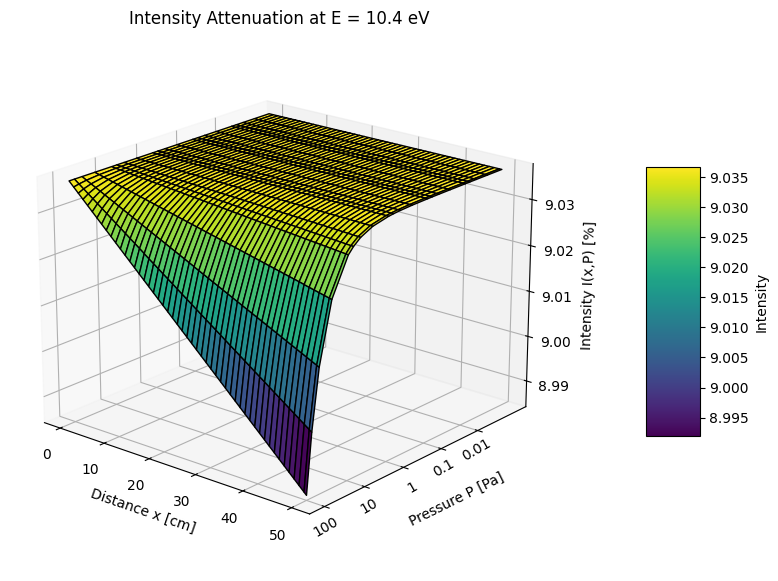

In [218]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
h = 6.626e-34  # Planck's constant (J·s)
c = 3.0e8  # Speed of light (m/s)
k_B = 1.38e-23  # J/K (Boltzmann constant)
P = 100  # Pressure in Pascals (example)
T = 300  # Temperature in Kelvin (example)
Pre = np.array([0.001,0.0025,0.005,0.0075,0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100])  # Convert atm to Pa


# Convert Mb to cm² (1 Mb = 1e-18 cm²)
Mb_to_cm2 = 1e-18

# Convert to correct units
sigma_E = extracted_ethanol * Mb_to_cm2  # σ in cm²
I0_E = extracted_vuv
theta_deg = smooth_theta_vuv  # θ in degrees
w_theta = smooth_dis_vuv

# Calculate gas number density (molecules/cm³)
n = np.array(Pre) / (k_B * T) * 1e-6  # Convert from m³ to cm³

# Define distance range
x_values = np.linspace(0, 50, 100)  # x in cm

# Compute attenuated intensity I(x, E)
I_x_E = np.zeros((len(x_values), len(energy_range),len(Pre)))

# ✅ Fix the computation of attenuated intensity
for i, x in enumerate(x_values):  # Loop over distances
    for j, P in enumerate(Pre):  # Loop over different pressures
        I_x_E[i, :, j] = I0_E * np.exp(-sigma_E * n[j] * x)  # Ensure correct indexing

# Check some sample values
print("I_x_E shape:", I_x_E.shape)  # Should be (100, len(energy_range), len(Pre))
print("Sample I_x_E values:", I_x_E[:, 0, :])  # Check if values change with Pre

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure(figsize=(25, 7))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for distance (x) and pressure (P)
X, Y = np.meshgrid(x_values, Pre)  # X (distance), Y (pressure)

# Select the last energy index (highest energy) for visualization
energy_index = len(energy_range)-15  # Last energy in the list

# Get intensity values for the selected energy
Z = I_x_E[:, energy_index, :].T  # Transpose to match (pressure, distance)
# Convert Pressure to log scale for visualization
Y_log = np.log10(Y)

# Plot surface with log-transformed pressure axis
surf = ax.plot_surface(X, Y_log, Z, cmap='viridis', edgecolor='k')

yticks = [0.01,0.1,1,10,100]
# Labels and title
ax.set_xlabel("Distance x [cm]")
ax.set_ylabel("Pressure P [Pa]")
ax.set_zlabel("Intensity I(x,P) [%]")
ax.set_title(f"Intensity Attenuation at E = {energy_range[energy_index]:.1f} eV")
# Adjust y-ticks to show real pressure values in log scale
ax.set_yticks(np.log10(yticks))  # Set log-ticks
ax.set_yticklabels(yticks, rotation=30, va="center", ha="right")  # Pr

# ✅ Flip the Y-axis direction
ax.invert_yaxis()  # This inverts the Y-axis

# ✅ Set viewing angle to adjust axis orientation
ax.view_init(elev=20, azim=310)  # Change azimuth & elevation

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label="Intensity")

plt.show()


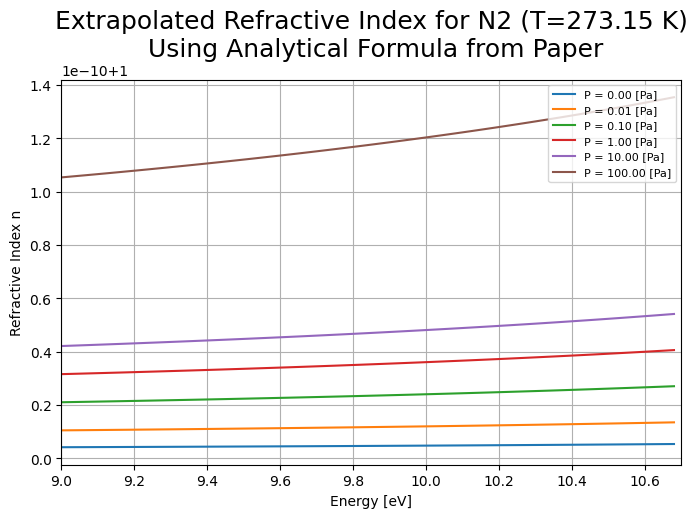

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants
T_std = 273.15  # Standard Temperature (K)
P_std = 101325  # Standard Pressure (Pa)
Pre = np.array([0.001,0.0025,0.005,0.0075,0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100])  # Convert atm to Pa

# Define energy range (9.0 to 10.7 eV)
energy_range = np.arange(9.0, 10.7, 0.02)

# ✅ Convert energy (eV) to wavenumber (σ in μm⁻¹)
sigma = (energy_range * 1e3) / 1240  # σ = (E * 10^3) / 1240

# ✅ Compute refractivity using the given formula
R_std = (1.9662731e6 / (22086.66 - sigma**2)) + (2.7450825e4 / (133.85688 - sigma**2))

# ✅ Convert R to refractive index at standard conditions
n_std = 1 + R_std / 1e6  # n = 1 + R / 10⁶

# # ✅ Define temperature & pressure values
# ✅ Compute compressibility factors Z
Z_std = 1 - (P_std * (317.6 - T_std) * 1e-5) / 101325
Z_actual = 1 - (Pre * (317.6 - T) * 1e-5) / 101325  # Adjust for each pressure

# ✅ Compute refractive index for different pressures
# n_actual = 1 + ((n_std - 1) * (Pre[:, np.newaxis] * T_std) / (P_std * T) * (Z_actual / Z_std) *
#                 (1 + (n_std - 1) / 6 * (1 - (P_std * T) / (Pre[:, np.newaxis] * T_std))))
n_actual = np.zeros((len(Pre), len(n_std)))
for i in np.arange(0,len(Pre),1):
    for j in np.arange(0,len(n_std),1):
        n_actual[i,j] = 1 + (n_std[j] - 1)/(
                            (P_std * T*Z_actual[i])/(Pre[i] * T_std * Z_std) *
                            (1 + (n_std[j] - 1) / 6 * (1 - Pre[i] * T_std /(P_std * T)))
                            )
# ✅ Plot results
plt.figure(figsize=(8, 5))

Pre_show = []
for i in np.arange(0,len(Pre),4):
    Pre_show.append(Pre[i])
for i, p in enumerate(Pre_show):
    plt.plot(energy_range, n_actual[i,:], label=f"P = {p:.2f} [Pa]")

plt.xlabel("Energy [eV]")
plt.ylabel("Refractive Index n")
plt.xlim(9.0, 10.7)  # Set x-axis range (Energy in eV)
plt.title(f"Extrapolated Refractive Index for N2 (T={T} K)\n Using Analytical Formula from Paper", fontsize=18)
plt.legend(loc="upper right", fontsize=8)
plt.grid()
plt.show()


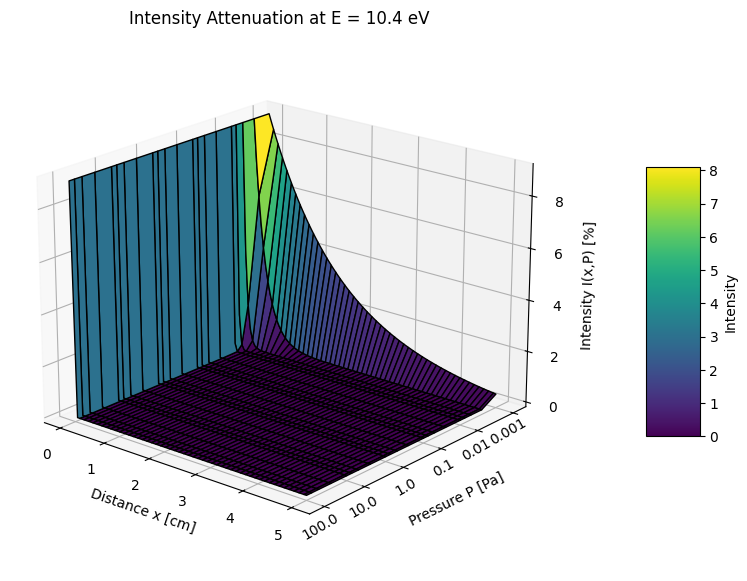

In [233]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Constants
h = 6.626e-34  # Planck's constant (J·s)
c = 3.0e8  # Speed of light (m/s)
k_B = 1.38e-23  # J/K (Boltzmann constant)
T = 300  # Temperature in Kelvin


# Convert energy (eV) to wavelength (m)
wavelength = 1240/ energy_range*1e-7 # Convert eV to meters
# ✅ Compute gas number density N0 (molecules/m³)
N0 = (Pre[:, np.newaxis] / (k_B * T)) *1e-6 # Shape: (len(Pre), len(energy_range))

# ✅ Compute Rayleigh scattering cross-section
cross_section_N2 = (16 * np.pi**3 * (n_actual - 1)**2) / (N0 * wavelength**4)  # Shape: (len(Pre), len(energy_range))

# ✅ Define distance range
x_values = np.linspace(0, 5, 100)  # Distance in cm

# ✅ Compute attenuated intensity I(x, E) using Beer's Law
I_x_E = np.zeros((len(x_values), len(energy_range), len(Pre)))

for i, x in enumerate(x_values):  # Loop over distances
    for j, P in enumerate(Pre):  # Loop over different pressures
        I_x_E[i, :, j] = I0_E * np.exp(-cross_section_N2[j, :] * N0[j, :] * x)  # Ensure correct indexing


#######
#######
# ✅ Create a 3D figure
fig = plt.figure(figsize=(25, 7))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for distance (x) and pressure (P)
X, Y = np.meshgrid(x_values, Pre)  # X (distance), Y (pressure)

# Select an energy index (e.g., last energy value)
energy_index = len(energy_range) - 15

# Get intensity values for the selected energy
Z = I_x_E[:, energy_index, :].T  # Transpose to match (pressure, distance)

# Convert Pressure to log scale for visualization
Y_log = np.log10(Y)

# ✅ Plot surface with log-transformed pressure axis
surf = ax.plot_surface(X, Y_log, Z, cmap='viridis', edgecolor='k')

Pre_show = []
for i in np.arange(0,len(Pre),4):
    Pre_show.append(Pre[i])
# Labels and title
ax.set_xlabel("Distance x [cm]")
ax.set_ylabel("Pressure P [Pa]")
ax.set_zlabel("Intensity I(x,P) [%]")
ax.set_title(f"Intensity Attenuation at E = {energy_range[energy_index]:.1f} eV")
# Adjust y-ticks to show real pressure values in log scale
ax.set_yticks(np.log10(Pre_show))
ax.set_yticklabels(Pre_show, rotation=30, va="center", ha="right")

# ✅ Flip the Y-axis direction
ax.invert_yaxis()

# ✅ Set viewing angle to adjust axis orientation
ax.view_init(elev=20, azim=310)

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label="Intensity")

plt.show()



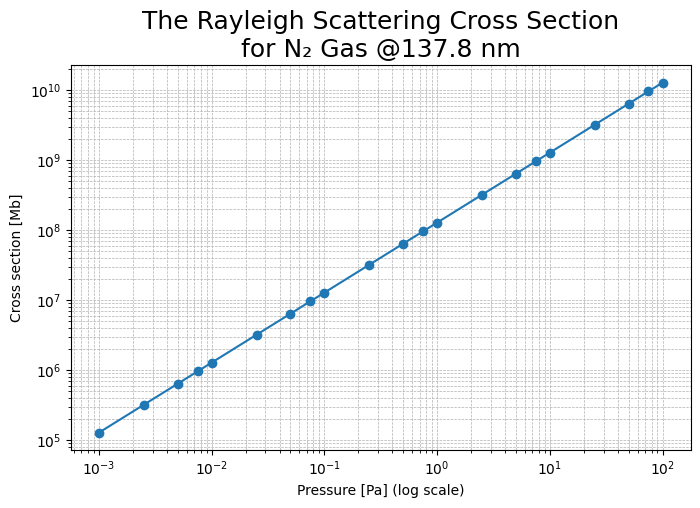

In [214]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
k_B = 1.38e-23  # Boltzmann constant (J/K)
T = 273.15  # Temperature (K)
Pre = np.array([0.001,0.0025,0.005,0.0075,0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100])  # Convert atm to Pa

wavelength_cm = 1240/energy_range[0]*1e-7 # Wavelength in cm (120 nm = 120 × 10⁻⁷ cm)
n_N2 = n_actual[:,0]  # Correct refractive index at 532 nm

# Compute number density N0 (in cm^-3)
N0 = (Pre / (k_B * T)) * 1e-6  # Convert from m^-3 to cm^-3

# Compute Rayleigh scattering cross-section (integrated)
cross_section_N2 = (8 * np.pi**3 / 3) * ((n_N2 - 1)**2) / (N0 * wavelength_cm**4)

# Convert to Megabarns (Mb), where 1 Mb = 10^-18 cm^2
cross_section_N2_Mb = cross_section_N2 * 1e18  

# Plot
plt.figure(figsize=(8, 5))
plt.plot(P, cross_section_N2_Mb, marker='o', linestyle='-', label="Rayleigh Cross Section")

# Set log scale for x-axis
plt.xscale("log")
plt.yscale("log")

plt.xlabel("Pressure [Pa] (log scale)")
plt.ylabel("Cross section [Mb]")
plt.title("The Rayleigh Scattering Cross Section\nfor N₂ Gas @{:.1f} nm".format(wavelength_cm*1e7), fontsize=18)
# plt.legend(loc="upper left", fontsize=12)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

plt.show()


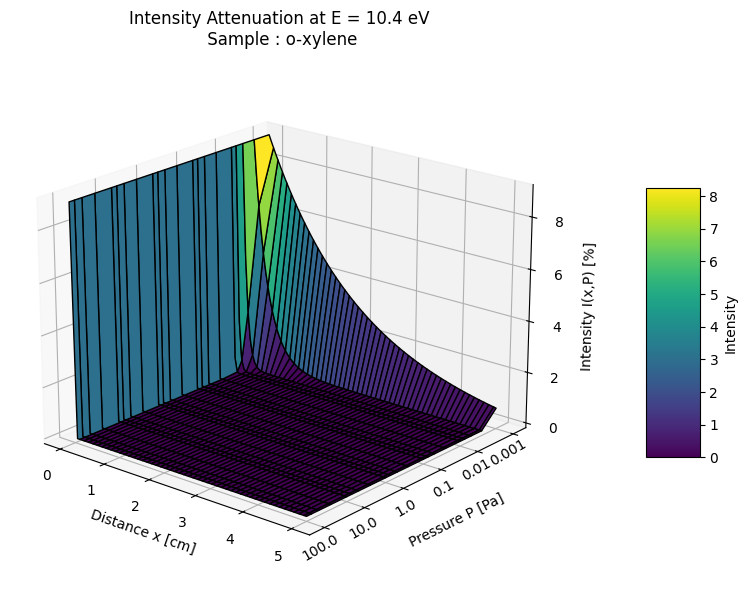

In [363]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


# Constants
h = 6.626e-34  # Planck's constant (J·s)
c = 3.0e8  # Speed of light (m/s)
k_B = 1.38e-23  # J/K (Boltzmann constant)
P = 100  # Pressure in Pascals (example)
T = 300  # Temperature in Kelvin (example)
Pre = np.array([0.001,0.0025,0.005,0.0075,0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100])  # Convert atm to Pa
x_values = np.linspace(0, 5, 100)  # x in cm

###
Sample_ID = 1
# Select the last energy index (highest energy) for visualization
energy_index = len(energy_range)-15  # Last energy in the list
Pre_index = 0
###


# Constants
T_std = 273.15  # Standard Temperature (K)
P_std = 101325  # Standard Pressure (Pa)
P_sat = np.array([8.8e2,248e2,55.8e2,13.2, 17e2] )
P_sat_ID = P_sat[Sample_ID-1] 
mol_frac_sample = P_sat_ID/P_std
mol_frac_N2 = 1-mol_frac_sample

# Define energy range (9.0 to 10.7 eV)
energy_range = np.arange(9.0, 10.7, 0.02)

#########
#########
# Convert Mb to cm² (1 Mb = 1e-18 cm²)
Mb_to_cm2 = 1e-18

# Convert to correct units
sigma_E = extracted_ethanol * Mb_to_cm2  # σ in cm²
I0_E = extracted_vuv
theta_deg = smooth_theta_vuv  # θ in degrees
w_theta = smooth_dis_vuv

# Calculate gas number density (molecules/cm³)
n = Pre / (k_B * T) * 1e-6  # Convert from m³ to cm³

# Compute attenuated intensity I(x, E)
I_x_E = np.zeros((len(x_values), len(energy_range),len(Pre)))


#########
#########
# ✅ Convert energy (eV) to wavenumber (σ in μm⁻¹)
sigma = (energy_range * 1e3) / 1240  # σ = (E * 10^3) / 1240

# ✅ Compute refractivity using the given formula
R_std = (1.9662731e6 / (22086.66 - sigma**2)) + (2.7450825e4 / (133.85688 - sigma**2))

# ✅ Convert R to refractive index at standard conditions
n_std = 1 + R_std / 1e6  # n = 1 + R / 10⁶

# # ✅ Define temperature & pressure values
# ✅ Compute compressibility factors Z
Z_std = 1 - (P_std * (317.6 - T_std) * 1e-5) / 101325
Z_actual = 1 - (Pre * (317.6 - T) * 1e-5) / 101325  # Adjust for each pressure

# ✅ Compute refractive index for different pressures
# n_actual = 1 + ((n_std - 1) * (Pre[:, np.newaxis] * T_std) / (P_std * T) * (Z_actual / Z_std) *
#                 (1 + (n_std - 1) / 6 * (1 - (P_std * T) / (Pre[:, np.newaxis] * T_std))))
n_actual = np.zeros((len(Pre), len(n_std)))
for i in np.arange(0,len(Pre),1):
    for j in np.arange(0,len(n_std),1):
        n_actual[i,j] = 1 + (n_std[j] - 1)/(
                            (P_std * T*Z_actual[i])/(Pre[i] * T_std * Z_std) *
                            (1 + (n_std[j] - 1) / 6 * (1 - Pre[i] * T_std /(P_std * T)))
                            )


#######
#######
# Convert energy (eV) to wavelength (m)
wavelength = 1240/ energy_range*1e-7 # Convert eV to meters
# ✅ Compute gas number density N0 (molecules/m³)
N0 = (Pre[:, np.newaxis] / (k_B * T)) *1e-6 # Shape: (len(Pre), len(energy_range))

# ✅ Compute Rayleigh scattering cross-section
cross_section_N2 = (16 * np.pi**3 * (n_actual - 1)**2) / (N0 * wavelength**4)  # Shape: (len(Pre), len(energy_range))
#cross_section_N2 = [pre,energy]


########
########

# ✅ Fix the computation of attenuated intensity
for i, x in enumerate(x_values):  # Loop over distances
    for j, P in enumerate(Pre):  # Loop over different pressures
        I_x_E[i, :, j] = I0_E * np.exp(-(mol_frac_sample*sigma_E+mol_frac_N2*cross_section_N2[j,:]) * n[j] * x)  # Ensure correct indexing

# # Check some sample values
# print("I_x_E shape:", I_x_E.shape)  # Should be (100, len(energy_range), len(Pre))
# print("Sample I_x_E values:", I_x_E[:, 0, :])  # Check if values change with Pre


#######
#######
# Create a 3D figure
fig = plt.figure(figsize=(25, 7))
ax = fig.add_subplot(111, projection='3d')

# Create meshgrid for distance (x) and pressure (P)
X, Y = np.meshgrid(x_values, Pre)  # X (distance), Y (pressure)

# Get intensity values for the selected energy
Z = I_x_E[:, energy_index, :].T  # Transpose to match (pressure, distance)
# Convert Pressure to log scale for visualization
Y_log = np.log10(Y)

# Plot surface with log-transformed pressure axis
surf = ax.plot_surface(X, Y_log, Z, cmap='viridis', edgecolor='k')

Pre_show = []
for i in np.arange(0,len(Pre),4):
    Pre_show.append(Pre[i])
# Labels and title
ax.set_xlabel("Distance x [cm]")
ax.set_ylabel("Pressure P [Pa]")
ax.set_zlabel("Intensity I(x,P) [%]")
ax.set_title(f"Intensity Attenuation at E = {energy_range[energy_index]:.1f} eV\n Sample : {names[Sample_ID-1]}")
# Adjust y-ticks to show real pressure values in log scale
ax.set_yticks(np.log10(Pre_show))  # Set log-ticks
ax.set_yticklabels(Pre_show, rotation=30, va="center", ha="right")  # Pr

# ✅ Flip the Y-axis direction
ax.invert_yaxis()  # This inverts the Y-axis

# ✅ Set viewing angle to adjust axis orientation
ax.view_init(elev=20, azim=310)  # Change azimuth & elevation

# Add color bar
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5, label="Intensity")

plt.show()


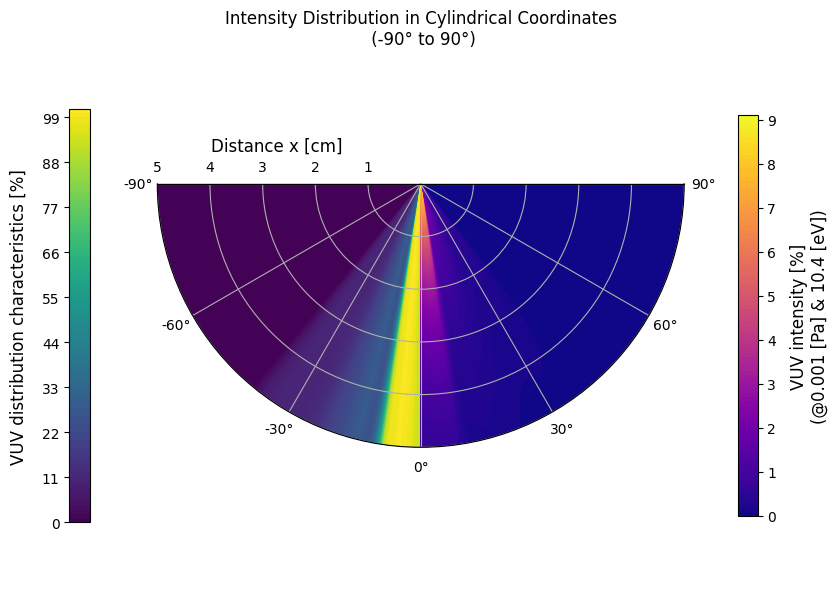

In [372]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load VUV lamp orientation characteristic data (relative intensity vs. angle)
file_path = "VUV_direction_distribution.csv"
vuv_data = pd.read_csv(file_path, header=None)
relative_intensity = vuv_data[0].values  # Relative intensity (0-1)
angles_deg = vuv_data[1].values  # Angles in degrees

# Convert angles to radians for plotting
angles_rad = np.radians(angles_deg)

# Interpolate relative intensity for smooth plotting
theta_range = np.linspace(0, np.pi, 180)  # Full circle
interp_func = interp1d(angles_rad, relative_intensity, kind="cubic", fill_value="extrapolate")
relative_intensity_interp = interp_func(theta_range)  # Interpolated intensities
relative_intensity_interp = np.maximum(relative_intensity_interp, 0)
# Define cylindrical coordinates
x_values = np.linspace(0, 5, 100)  # Distance range in cm
X, Theta = np.meshgrid(x_values, theta_range)  # Create grid

# Example I_x_E(x, E, P) assuming a fixed energy and pressure
# Replace this with actual I_x_E data from previous calculations
I_x_E_sample = np.ones((180, 100))  # Example decay profile


# Compute total intensity distribution considering VUV lamp emission pattern
intensity_vuv_dis = I_x_E_sample * relative_intensity_interp[:, np.newaxis]
intensity_cylindrical_0 = I_x_E[:,energy_index,Pre_index] * relative_intensity_interp[:, np.newaxis]
intensity_cylindrical = I_x_E_0 * relative_intensity_interp[:, np.newaxis, np.newaxis]




# Create a figure and polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 6))

# Left-side plot (-90° to 0°)
c1 = ax.contourf(-Theta, X, intensity_vuv_dis*100, levels=100, cmap="viridis")

# Right-side plot (0° to 90°) - mirrored
c2 = ax.contourf(Theta, X, intensity_cylindrical_0, levels=100, cmap="plasma")

# Set limits
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_ylim(0, 5)

# Adjust theta labels
ax.set_xticks(np.radians([-90, -60, -30, 0, 30, 60, 90]))
ax.set_xticklabels(["-90°", "-60°", "-30°", "0°", "30°", "60°", "90°"])

ax.set_theta_zero_location("S")  # Set zero angle to the top
# ✅ Set R-axis labels (Distance in cm)
ax.set_yticks([1, 2, 3, 4, 5])  # Show tick marks at these radii
ax.set_yticklabels(["1", "2", "3", "4", "5"])  # Label them as distance in cm
ax.text(-1.8, 2.8, "Distance x [cm]", ha="center", fontsize=12)  # Move label above ylim

# Labels and title
ax.set_title("Intensity Distribution in Cylindrical Coordinates\n (-90° to 90°)")

# ✅ Move colorbar1 **closer to ax**
cbar1 = fig.colorbar(c1, ax=ax, fraction=0.03, pad=0.0, location="left")  # Decreased pad
cbar1.set_label("VUV distribution characteristics [%]", size=12, labelpad=10)


# ✅ Keep colorbar2 on the RIGHT side
cbar2 = fig.colorbar(c2, ax=ax, fraction=0.03, pad=0.08, location="right")  # Adjusted for balance
cbar2.set_label("VUV intensity [%]\n(@{} [Pa] & {} [eV])".format(Pre[Pre_index],round(energy_range[energy_index],1)), size=12, labelpad=10)

# Get the current axis position
ax_pos = ax.get_position()

# Shift the plot to the center
ax.set_position([0.1, ax_pos.y0, 1.05, ax_pos.height])  # (x, y, width, height)

# Shift colorbars accordingly
cbar1.ax.set_position([ax_pos.x0 - 0.02, ax_pos.y0, 0.02, ax_pos.height])  # Move left colorbar
cbar2.ax.set_position([ax_pos.x1 + 0.02, ax_pos.y0, 0.02, ax_pos.height])  # Move right colorbar


plt.tight_layout()
plt.show()

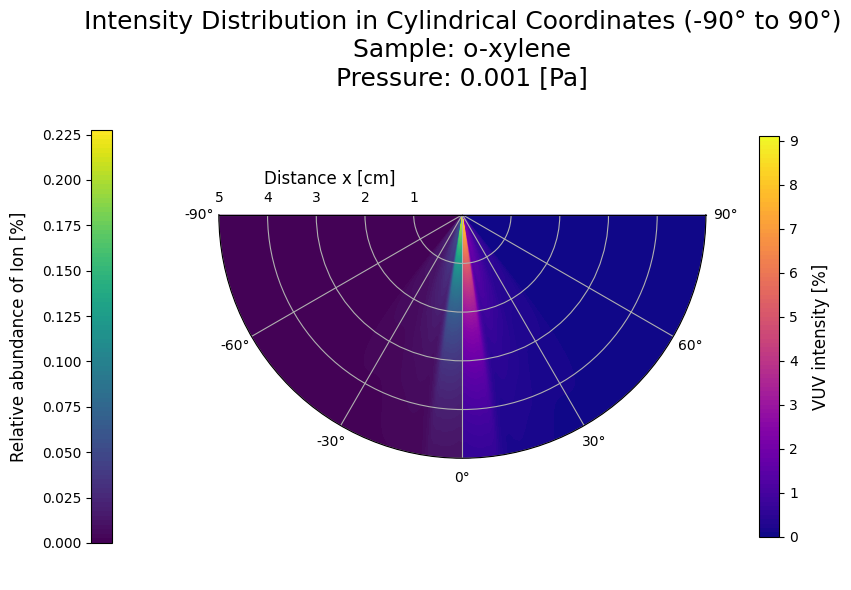

In [384]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load VUV lamp orientation characteristic data (relative intensity vs. angle)
file_path = "VUV_direction_distribution.csv"
vuv_data = pd.read_csv(file_path, header=None)
relative_intensity = vuv_data[0].values  # Relative intensity (0-1)
angles_deg = vuv_data[1].values  # Angles in degrees

# Convert angles to radians for plotting
angles_rad = np.radians(angles_deg)

# Interpolate relative intensity for smooth plotting
theta_range = np.linspace(0, np.pi, 180)  # Full circle
interp_func = interp1d(angles_rad, relative_intensity, kind="cubic", fill_value="extrapolate")
relative_intensity_interp = interp_func(theta_range)  # Interpolated intensities
relative_intensity_interp = np.maximum(relative_intensity_interp, 0)
# Define cylindrical coordinates
x_values = np.linspace(0, 5, 100)  # Distance range in cm
X, Theta = np.meshgrid(x_values, theta_range)  # Create grid

# Example I_x_E(x, E, P) assuming a fixed energy and pressure
# Replace this with actual I_x_E data from previous calculations
I_x_E_sample = np.ones((180, 100))  # Example decay profile


# Compute total intensity distribution considering VUV lamp emission pattern
intensity_vuv_dis = I_x_E_sample * relative_intensity_interp[:, np.newaxis]
intensity_cylindrical_0 = I_x_E[:,energy_index,Pre_index] * relative_intensity_interp[:, np.newaxis]



#####
Nom_of_ion = []
for i in np.arange(0,len(x_values),1):
    Nom_of_ion.append(sum(n[Pre_index]*sigma_E[:]*I_x_E[i,:,Pre_index]))
Nom_of_ion = np.array(Nom_of_ion)
intensity_cylindrical = Nom_of_ion[np.newaxis,:]* relative_intensity_interp[:,np.newaxis]
intensity_cylindrical = intensity_cylindrical/np.sum(intensity_cylindrical) *100



# Create a figure and polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(10, 6))

# Left-side plot (-90° to 0°)
c1 = ax.contourf(-Theta, X, intensity_cylindrical, levels=100, cmap="viridis")

# Right-side plot (0° to 90°) - mirrored
c2 = ax.contourf(Theta, X, intensity_cylindrical_0, levels=100, cmap="plasma")

# Set limits
ax.set_thetamin(-90)
ax.set_thetamax(90)
ax.set_ylim(0, 5)

# Adjust theta labels
ax.set_xticks(np.radians([-90, -60, -30, 0, 30, 60, 90]))
ax.set_xticklabels(["-90°", "-60°", "-30°", "0°", "30°", "60°", "90°"])

ax.set_theta_zero_location("S")  # Set zero angle to the top
# ✅ Set R-axis labels (Distance in cm)
ax.set_yticks([1, 2, 3, 4, 5])  # Show tick marks at these radii
ax.set_yticklabels(["1", "2", "3", "4", "5"])  # Label them as distance in cm
ax.text(-1.8, 2.8, "Distance x [cm]", ha="center", fontsize=12)  # Move label above ylim

# Labels and title
ax.set_title("Intensity Distribution in Cylindrical Coordinates (-90° to 90°)\nSample: {}\nPressure: {} [Pa]".format(names[Sample_ID-1],Pre[Pre_index]), fontsize=18)

# ✅ Move colorbar1 **closer to ax**
cbar1 = fig.colorbar(c1, ax=ax, fraction=0.03, pad=0.0, location="left")  # Decreased pad
cbar1.set_label("Relative abundance of Ion [%]", size=12, labelpad=10)


# ✅ Keep colorbar2 on the RIGHT side
cbar2 = fig.colorbar(c2, ax=ax, fraction=0.03, pad=0.08, location="right")  # Adjusted for balance
cbar2.set_label("VUV intensity [%]", size=12, labelpad=10)

# Get the current axis position
ax_pos = ax.get_position()

# Shift the plot to the center
ax.set_position([0.1, ax_pos.y0, 1.05, ax_pos.height])  # (x, y, width, height)

# Shift colorbars accordingly
cbar1.ax.set_position([ax_pos.x0 - 0.02, ax_pos.y0, 0.02, ax_pos.height])  # Move left colorbar
cbar2.ax.set_position([ax_pos.x1 + 0.02, ax_pos.y0, 0.02, ax_pos.height])  # Move right colorbar


plt.tight_layout()
plt.show()

In [274]:
I_x_E[:,len(energy_range)-15,0]

array([9.03665115, 8.74499304, 8.46274821, 8.18961284, 7.92529292,
       7.66950393, 7.42197053, 7.18242628, 6.95061332, 6.72628213,
       6.50919124, 6.29910696, 6.09580315, 5.89906098, 5.70866866,
       5.52442126, 5.34612045, 5.17357431, 5.00659709, 4.84500906,
       4.6886363 , 4.53731046, 4.39086868, 4.2491533 , 4.11201179,
       3.97929652, 3.85086465, 3.72657791, 3.60630253, 3.48990904,
       3.37727216, 3.26827063, 3.16278713, 3.06070811, 2.96192369,
       2.86632754, 2.77381676, 2.68429177, 2.59765619, 2.51381679,
       2.4326833 , 2.3541684 , 2.27818756, 2.20465901, 2.1335036 ,
       2.06464472, 1.99800827, 1.93352251, 1.87111804, 1.81072766,
       1.75228639, 1.69573131, 1.64100155, 1.58803819, 1.53678422,
       1.48718448, 1.43918557, 1.39273583, 1.34778525, 1.30428545,
       1.26218961, 1.22145242, 1.18203002, 1.14387997, 1.10696122,
       1.07123403, 1.03665993, 1.00320171, 0.97082335, 0.93949001,
       0.90916795, 0.87982453, 0.85142818, 0.82394832, 0.79735